## Property modeling EGU25

This notebook is a small example of how to populate a structural geological model with properties using geostaistical methods. 

In addition to gempy it requires pyvista (https://pyvista.org/) and gstools (https://geostat-framework.readthedocs.io/projects/gstools/en/stable/) as dependencies.

In [1]:
# Importing necessary libraries
import numpy as np
import gempy as gp
import gempy_viewer as gpv

# Additional dependencies
import pyvista as pv
import matplotlib.pyplot as plt
import gstools as gs

Setting Backend To: AvailableBackends.numpy


### 1) Strucutural geological model 

In [2]:
# Generate the model
data_path = 'https://raw.githubusercontent.com/cgre-aachen/gempy_data/master/'
path_to_data = data_path + "/data/input_data/jan_models/"

# Create a GeoModel instance
geo_model = gp.create_geomodel(
    project_name='combination',
    extent=[0, 2500, 0, 1000, 0, 1000],
    resolution=[125, 50, 50],
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations=path_to_data + "model7_orientations.csv",
        path_to_surface_points=path_to_data + "model7_surface_points.csv"
    )
)

# Map geological series to surfaces
gp.map_stack_to_surfaces(
    gempy_model=geo_model,
    mapping_object={
        "Fault_Series": ('fault'),
        "Strat_Series1": ('rock3'),
        "Strat_Series2": ('rock2', 'rock1'),
    }
)
# Define youngest structural group as fault
gp.set_is_fault(geo_model, ["Fault_Series"])

# Compute the geological model
gp.compute_model(geo_model)

Surface points hash:  dd7b2f714c1c20cb7ce615c5c47ecc4cf3ca2ee3419e4090b2f11fbf633d459f
Orientations hash:  4043b59bbfa7012abd818f04f74e2b0667ba970dd71c781512289bc073f5a6d5
Setting Backend To: AvailableBackends.numpy
Chunking done: 6 chunks
Chunking done: 14 chunks
Chunking done: 66 chunks
Chunking done: 6 chunks


Solutions(4 Octree Levels, 4 DualContouringMeshes)

In [3]:
gpv.plot_3d(geo_model, show_block=True, show_lith=True, show_data=False)

### 2) Convert to block model 

In [4]:
# Just for completeness - get the extent from gempy model
model_extent = geo_model.grid.extent

In [5]:
# Creat a structured pyvista grid from a gempy model

# Define grid dimensions (number of voxels along each axis)
nx, ny, nz = 125, 50, 50  # Number of voxels in each direction (res)

# Define the range for x, y, z and calculate voxel centers
dx = 2500 / nx
dy = 1000 / ny
dz = 1000 / nz

# Similar to gempy grid bur plus one for meshing
gridx = np.linspace(0, 2500, nx+1)
gridy = np.linspace(0, 1000, ny+1)
gridz = np.linspace(0, 1000, nz+1)

# Create a 3D meshgrid for the coordinates, voxel centers
X, Y, Z = np.meshgrid(gridx, gridy, gridz, indexing="ij")

# Reshape the coordinates to fit into the StructuredGrid format
points = np.c_[X.T.ravel(), Y.T.ravel(), Z.T.ravel()]

# Create a PyVista StructuredGrid object
grid = pv.StructuredGrid()
grid.points = points
grid.dimensions = [nx+1, ny+1, nz+1] # One bigger as gempy grid

# Assign the voxel colors to the grid's cell data
grid.cell_data['lithology'] = geo_model.solutions.raw_arrays.lith_block.reshape([nx, ny, nz]).T.flatten(order="C")


In [6]:
# Pyvista strucutured grid
grid

StructuredGrid (0x1fa07cb58a0)
  N Cells:      312500
  N Points:     327726
  X Bounds:     0.000e+00, 2.500e+03
  Y Bounds:     0.000e+00, 1.000e+03
  Z Bounds:     0.000e+00, 1.000e+03
  Dimensions:   126, 51, 51
  N Arrays:     1

In [7]:
# 3D plot lithologies
plotter = pv.Plotter(notebook=False)

plotter.add_mesh(grid, scalars='lithology',  cmap=['#728f02', '#ffbe00', '#9f0052', '#443988'], show_edges=True, style="surface")

# Set the bounds and grid of the plotter
plotter.show_bounds(bounds=model_extent,
                    location="furthest",
                    grid=True)

# Display the interactive plot
plotter.show()

### 3) Perform Sequential Gaussian Simulation (SGS)

In [8]:
# Separate into multiblock by lithology ID
grid.set_active_scalars("lithology")
multi_mesh = pv.MultiBlock()

# There should be ab better soöution for this
for i in np.unique(geo_model.solutions.raw_arrays.lith_block):
    threshed = grid.threshold((i-0.5,i+0.5))
    multi_mesh.append(threshed)

In [9]:
# Pyvista multiblock
multi_mesh

MultiBlock (0x1fa07cb6c80)
  N Blocks:   4
  X Bounds:   0.000e+00, 2.500e+03
  Y Bounds:   0.000e+00, 1.000e+03
  Z Bounds:   0.000e+00, 1.000e+03

C:\Users\vonha\PycharmProjects\egu25_gempy_workshop\venv\Lib\site-packages\gstools\covmodel\plot.py:134: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


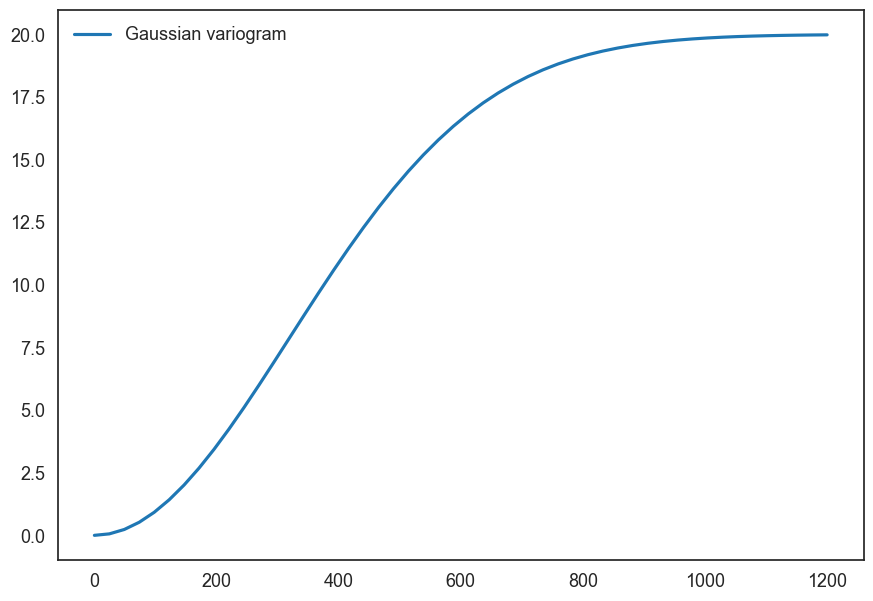

In [10]:
# Define a variogram model
var_model = gs.Gaussian(dim=3, var=20, len_scale=400)
var_model.plot();

In [11]:
# Pick a mesh (lithological unit) and get coordinates of cell centers
centers = multi_mesh[2].cell_centers()
x = centers.points[:,0]
y = centers.points[:,1]
z = centers.points[:,2]

# perform SGS
srf = gs.SRF(var_model, seed=20170519)
random_field = np.round(srf((x, y, z)), 0)

# Add result to the pyvista multiblock
multi_mesh[2].cell_data["property_values"]=random_field+20

In [12]:
# Look at result
multi_mesh[2]

UnstructuredGrid (0x1fa07cc1b40)
  N Cells:    52736
  N Points:   65130
  X Bounds:   0.000e+00, 2.500e+03
  Y Bounds:   0.000e+00, 1.000e+03
  Z Bounds:   2.400e+02, 8.000e+02
  N Arrays:   2

In [13]:
# Plot a single unit in 3D
plotter = pv.Plotter(notebook=False)

plotter.add_mesh(multi_mesh[2], show_edges=True, scalars="property_values")

plotter.show_bounds()
plotter.show()

### 4) Bonus: Example for all units

In [14]:
# Random field generation with random variogram models
# NOTE: I use random variograms here, so result might be weird
fields = []
for i in range(4):
    centers = multi_mesh[i].cell_centers()
    x = centers.points[:,0]
    y = centers.points[:,1]
    z = centers.points[:,2]
    model = gs.Gaussian(dim=3, var=np.random.randint(1,20), len_scale=np.random.random()*1000)
    srf = gs.SRF(model, seed=20170519)
    fields.append(np.round(srf((x, y, z)), 0))
    multi_mesh[i].cell_data["values"]=fields[i]+np.random.randint(1,20)

In [15]:
multi_mesh[2]

UnstructuredGrid (0x1fa07cc1b40)
  N Cells:    52736
  N Points:   65130
  X Bounds:   0.000e+00, 2.500e+03
  Y Bounds:   0.000e+00, 1.000e+03
  Z Bounds:   2.400e+02, 8.000e+02
  N Arrays:   3

In [16]:
# Plot all units
plotter = pv.Plotter(notebook=False)

for i in range(4):
    plotter.add_mesh(multi_mesh[i], show_edges=True, scalars="values")

plotter.show_bounds()
plotter.show()